## Perform standard imports

In [2]:
! pip install split-folders

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torchsummary import summary
import splitfolders
import numpy as np
import copy
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Define transforms

In [5]:
transform = transforms.Compose([ transforms.ToTensor(), # Normalizes to range [0,1]
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]), # Also part of normalization
                        transforms.Resize((224, 224))
                       ])

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd /content/drive/MyDrive/Convolutional Neural Network

/content/drive/MyDrive/Convolutional Neural Network


## Prepare train and test sets, loaders

In [8]:
splitfolders.ratio("CatDog", output="cat_dog",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False) # default values

Copying files: 1000 files [04:27,  3.73 files/s]


In [9]:
train_data = datasets.ImageFolder('cat_dog/train', transform = transform)
test_data = datasets.ImageFolder('cat_dog/val', transform = transform)

In [10]:
train_loader = DataLoader(train_data, batch_size = 32, shuffle=True,  drop_last = True)
test_loader = DataLoader(test_data, batch_size= 32,  drop_last = True)

class_names = train_data.classes # classes or labels or categories

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['cat', 'dog']
Training images available: 800
Testing images available:  200


## Display a batch of images


In [11]:
for images,labels in train_loader:
    break
images.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([32, 3, 224, 224])

In [12]:
labels

tensor([1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 0])

Label: [1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0]
Class: dog dog dog dog cat cat dog cat dog dog cat dog cat cat cat dog cat dog dog cat cat dog cat cat cat cat dog dog cat cat dog cat


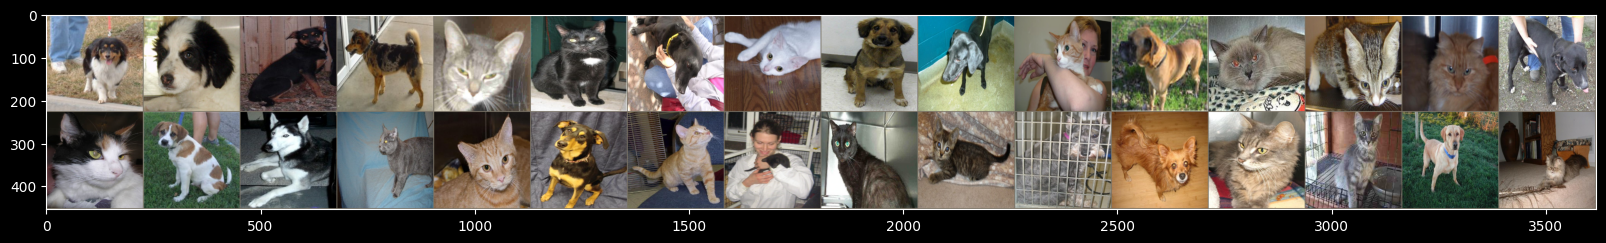

In [13]:
# Print the labels

print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=16)  # 16 images in a row
# Inverse normalize the images

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images

plt.figure(figsize=(20,16))
plt.imshow(np.transpose((im_inv.numpy()*255).astype(np.uint8), (1, 2, 0))); # we see that dataloader has shuffle the images

##  Import ResNet-18

In [14]:
resnet = torchvision.models.resnet18('ResNet18_Weights.DEFAULT')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 109MB/s]


In [15]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [1]:
# count the total number of parameters in the model
#summary(resnet.cuda(),(3,224,224))

# Freeze all the Layers

In [16]:
# Freeze all layers
for p in resnet.parameters():
    p.requires_grad = False


# Unfreeze and Change the Final Layer

In [20]:
 # Now we make later layers trainable
for param in resnet.layer4.parameters():
    param.requires_grad = True
for param in resnet.layer3.parameters():
    param.requires_grad = True
for param in resnet.avgpool.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
#num_ftrs = resnet.fc.in_features
# Replace 1 FC with 3 new FC

resnet.fc = nn.Sequential(
                nn.Linear(in_features=512, out_features=256, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=256, out_features=128, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=128, out_features=64, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=64, out_features=2, bias=True))


# Put ResNet on GPU

In [21]:
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Training and Testing the model

In [22]:
epochs = 20

# loss function

lossfunc = nn.CrossEntropyLoss()

# optimizer

optimizer = torch.optim.SGD(resnet.parameters(), momentum = 0.9, lr = 0.001)


  # Initialize losses and Accuracies

losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


# loop over epochs

for epoch in range(epochs):
 resnet.train()

 # loop over training data batches

 batchAcc  = []
 batchLoss = []
 for X,y in train_loader:

  X = X.to(device) # Placing features on device
  y = y.to(device) # placing labels on device

  ypred = resnet(X)
  loss = lossfunc(ypred,y)


  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Append batchloss

  batchLoss.append(loss.item())

  ypred = ypred.cpu() # Back to cpu
  y = y.cpu()

  # compute batch accuracy

  acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
  batchAcc.append(acc)
# Batch loop concluded

# Average training accuracy (Outside the batchloop)

 trainAcc.append(np.mean(batchAcc))

# Losses through epochs

 losses[epoch] = np.mean(batchLoss)

# TESTING the model

 resnet.eval()
 X,y = next(iter(test_loader))
 X = X.to(device)
 y = y.to(device)

 with torch.no_grad(): #This step  Deactivating autogradient
  ypred = resnet(X)
  ypred = ypred.cpu()
  y = y.cpu()

 # Appending test accuracy

  testAcc.append(100 * torch.mean((torch.argmax(ypred,dim=1)==y).float()))


  print(f' epochs : {epoch}  loss : {loss : 2.2f}')



 epochs : 0  loss :  0.69
 epochs : 1  loss :  0.69
 epochs : 2  loss :  0.65
 epochs : 3  loss :  0.62
 epochs : 4  loss :  0.57
 epochs : 5  loss :  0.46
 epochs : 6  loss :  0.35
 epochs : 7  loss :  0.17
 epochs : 8  loss :  0.14
 epochs : 9  loss :  0.05
 epochs : 10  loss :  0.12
 epochs : 11  loss :  0.05
 epochs : 12  loss :  0.03
 epochs : 13  loss :  0.01
 epochs : 14  loss :  0.02
 epochs : 15  loss :  0.03
 epochs : 16  loss :  0.01
 epochs : 17  loss :  0.00
 epochs : 18  loss :  0.00
 epochs : 19  loss :  0.00


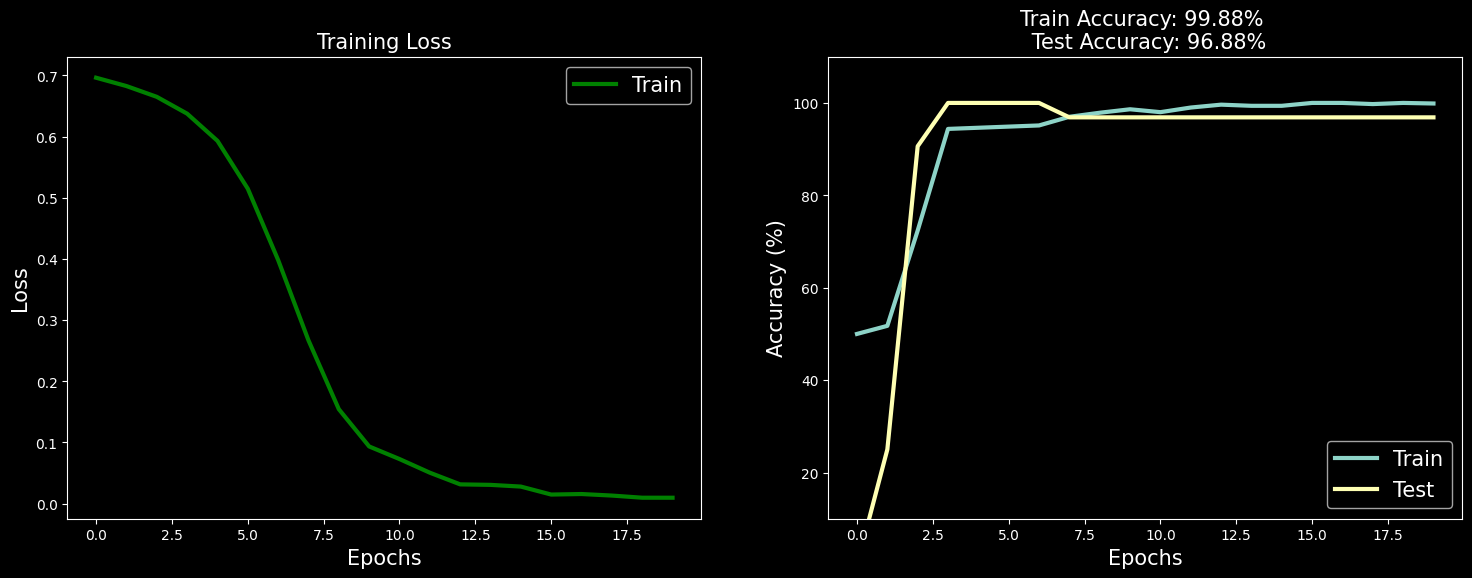

In [23]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()